Промаркируем топиками все единицы векторной базы

Инсталлы

In [1]:
! pip install --upgrade --quiet yandex-cloud-ml-sdk


Импорты

In [7]:
import os
from yandex_cloud_ml_sdk import YCloudML
import json
import pandas as pd
import ast
import matplotlib.pyplot as plt


Функция для запросов к модели

In [4]:


folder_id = os.environ["FOLDER_ID"]
api_key = os.environ["API_KEY"]

sdk = YCloudML(folder_id=folder_id, auth=api_key)
model = sdk.models.completions("yandexgpt", model_version="rc")


valid_topics = 'проходной балл, меганаправления, количество бюджетных мест, цена года обучения, общежития, индивидуальные достижения, компанни-партнеры, стажировки, математика, программирование, кафедры, преподаватели, стипендии, корпуса, ремонт, айти-этаж, лаборатории, подача заявления, дни открытых дверей, чат приемки, чаты меганаправлений, языки программирования, баллы на общежитие, сертификаты на общежитие, бви, магистратура, военная кафедра, культурные мероприятия, спортивные секции, спортивные соревнования'.split(', ') + ['мусор']
def tag_query(query):
    with open('../research/prompts/tagging_prompt.md', 'r', encoding='utf-8') as f:
        system_prompt = f.read()
    return model.run(system_prompt + "\n\n Входной запрос:\n" + query).text
tag_query('''Маник сделала, крутой капец
''')

KeyboardInterrupt: 

Слияние в один датафрейм

In [16]:
result = {'source': [], 'chunk_text': []}
result['source'] += list(pd.read_csv('../data/support/final_df.csv')['root_global_id'])
result['chunk_text'] += list(pd.read_csv('../data/support/final_df.csv')['dialog_plain'])
result['source'] += list(pd.read_csv('../data/support/pages_mai.csv')['url'])
result['chunk_text'] += list(pd.read_csv('../data/support/pages_mai.csv')['content'])
result['source'] += list(pd.read_csv('../data/support/pdf_df.csv')['doc_name'])
result['chunk_text'] += list(pd.read_csv('../data/support/pdf_df.csv')['dialog_plain'])
result['source'] += list(pd.read_csv('../data/support/vk_chunks_df.csv')['doc_name'])
result['chunk_text'] += list(pd.read_csv('../data/support/vk_chunks_df.csv')['dialog_plain'])
result_df = pd.DataFrame(result)


In [17]:
result_df

,source,chunk_text
0,chat2021_10,Возможность заселения в одну комнату знакомых/...
1,chat2021_10,Староста Задачи старосты\nПередавать информаци...
2,chat2021_10,Список документов для поступления (бакалавриат...
3,chat2021_10,Добрый день)\nЯляется ли обучение на направлен...
4,chat2021_10,"Доброй ночи, хотелось бы узнать как предоставл..."
...,...,...
4280,ФРЭЛА МАИ,[ФРЭЛА МАИ 💥 В рамках VI Фестиваля радиоэлектр...
4281,ФРЭЛА МАИ,"[ФРЭЛА МАИ Уже завтра в 13:00 Василий Егоров, ..."
4282,ФРЭЛА МАИ,[ФРЭЛА МАИ МАИ приглашает студентов и школьник...
4283,ФРЭЛА МАИ,[ФРЭЛА МАИ 🚀 Попробуй свои силы — участвуй в О...


Обработка диалогов

In [19]:
def add_query(query):
    ans = tag_query(query)

    topics = ans.strip().replace('[', '').replace(']', '').replace('\n\n\u200b', '').split(', ')
    res = []
    for i in topics:
        if i  in valid_topics:
            res.append(i)
    topics = res

    print(f'{query[:15]} -> {topics}')
    return topics

result_df['topics'] = result_df['chunk_text'].apply(add_query)

Возможность зас -> ['общежития', 'айти-этаж', 'кафедры', 'магистратура', 'программирование', 'математика', 'подача заявления']
Староста Задачи -> ['индивидуальные достижения', 'общежития', 'математика']
Список документ -> ['индивидуальные достижения', 'подача заявления', 'магистратура']
Добрый день)
Ял -> ['подача заявления', 'преподаватели']
Доброй ночи, хо -> ['проходной балл', 'общежития', 'количество бюджетных мест', 'баллы на общежитие']
Ок. Если Вы хот -> ['общежития', 'проходной балл', 'количество бюджетных мест', 'бви', 'подача заявления', 'чат приемки']
Здравствуйте! С -> ['подача заявления', 'общежития']
Нашел такой пос -> ['культурные мероприятия', 'спортивные секции']
Привет, студент -> ['спортивные секции', 'корпуса']
Привет! 
Хотел  -> ['стипендии', 'спортивные секции', 'спортивные соревнования', 'программирование', 'кафедры', 'магистратура', 'количество бюджетных мест']
А как вообще ра -> ['проходной балл', 'подача заявления', 'общежития']
Здравствуйте. П -> ['подача зая

Обработка  постов

In [21]:
result_df.to_csv('final_data_with_topics_nd_preprocess.csv')

## Анализ

In [5]:
df = pd.read_csv('final_data_with_topics_nd_preprocess.csv')
df

,Unnamed: 0,source,chunk_text,topics
0,0,chat2021_10,Возможность заселения в одну комнату знакомых/...,"['общежития', 'айти-этаж', 'кафедры', 'магистр..."
1,1,chat2021_10,Староста Задачи старосты\nПередавать информаци...,"['индивидуальные достижения', 'общежития', 'ма..."
2,2,chat2021_10,Список документов для поступления (бакалавриат...,"['индивидуальные достижения', 'подача заявлени..."
3,3,chat2021_10,Добрый день)\nЯляется ли обучение на направлен...,"['подача заявления', 'преподаватели']"
4,4,chat2021_10,"Доброй ночи, хотелось бы узнать как предоставл...","['проходной балл', 'общежития', 'количество бю..."
...,...,...,...,...
4280,4280,ФРЭЛА МАИ,[ФРЭЛА МАИ 💥 В рамках VI Фестиваля радиоэлектр...,['мусор']
4281,4281,ФРЭЛА МАИ,"[ФРЭЛА МАИ Уже завтра в 13:00 Василий Егоров, ...",['мусор']
4282,4282,ФРЭЛА МАИ,[ФРЭЛА МАИ МАИ приглашает студентов и школьник...,[]
4283,4283,ФРЭЛА МАИ,[ФРЭЛА МАИ 🚀 Попробуй свои силы — участвуй в О...,"['магистратура', 'стажировки']"


/tmp/ipykernel_13484/3819281165.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


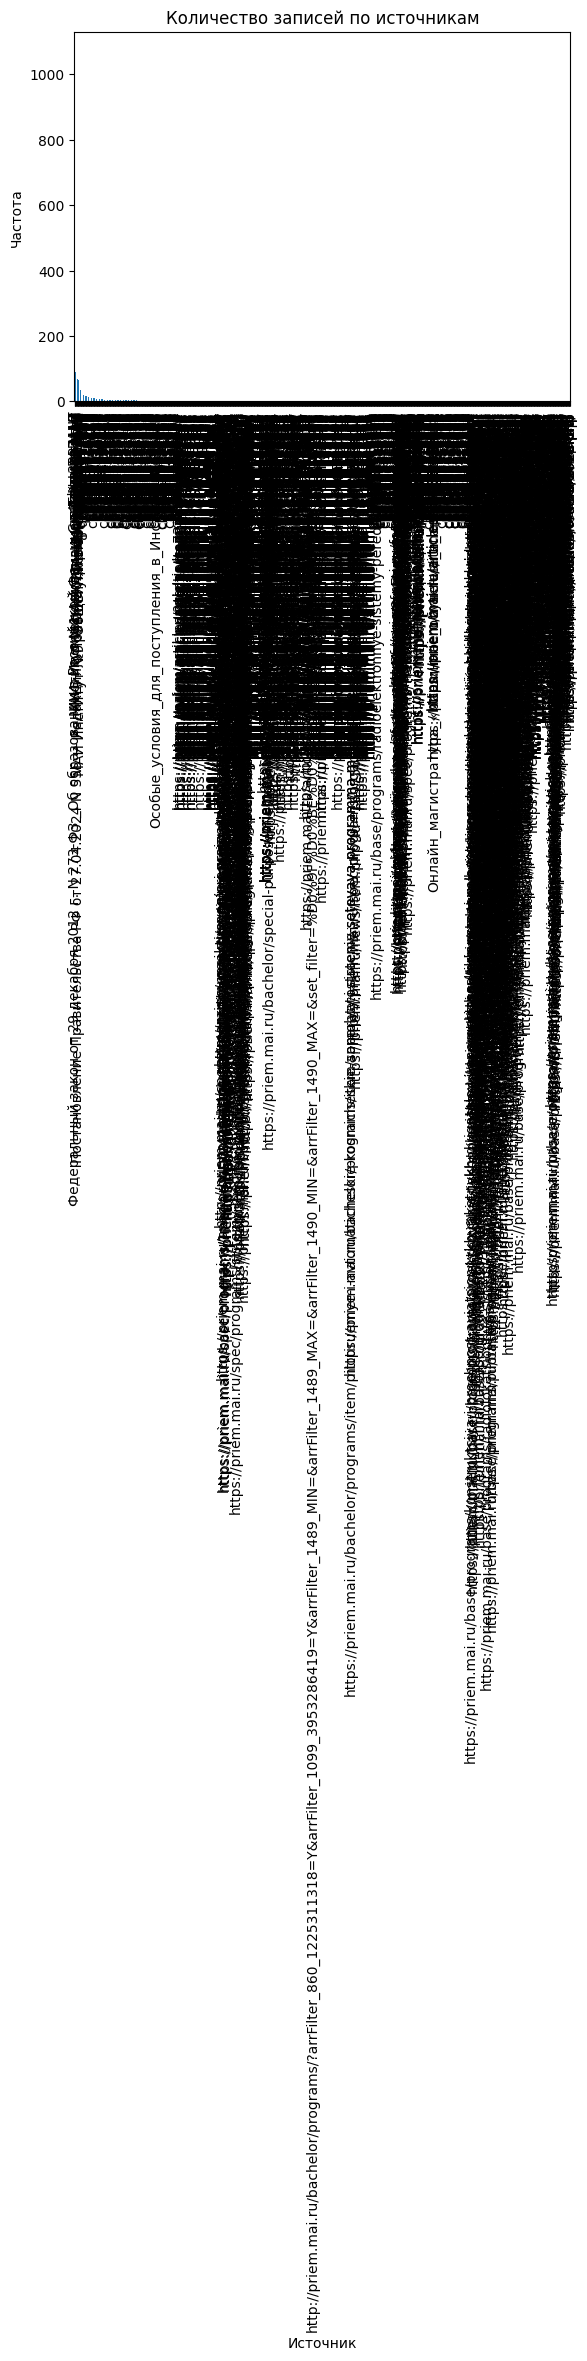

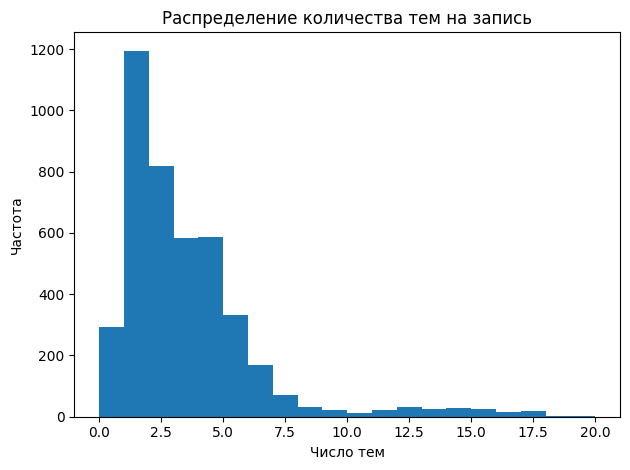

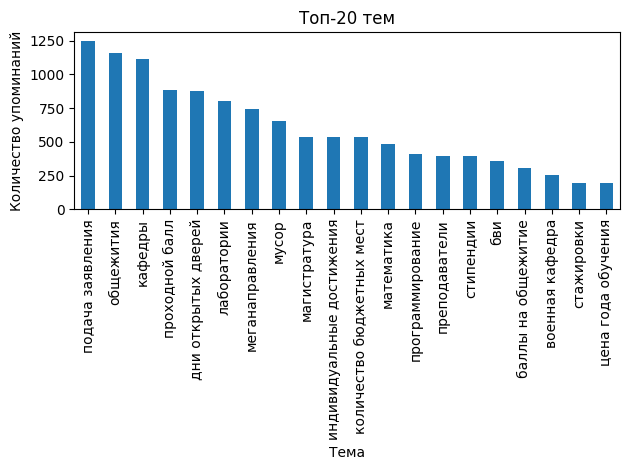

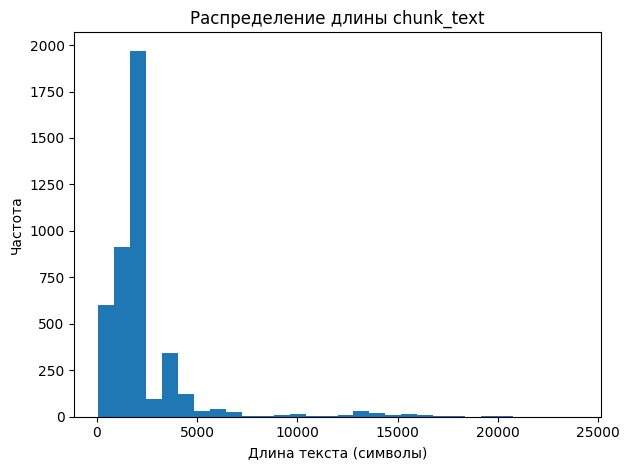

In [8]:


# Если df еще не загружен, раскомментируйте следующую строку и укажите корректный путь:
# df = pd.read_csv('path/to/df.csv')

# Преобразуем текстовое представление списка тем в настоящий список
df['topics_list'] = df['topics'].apply(ast.literal_eval)

# 1) Распределение записей по источникам
source_counts = df['source'].value_counts()
plt.figure()
source_counts.plot(kind='bar')
plt.title('Количество записей по источникам')
plt.xlabel('Источник')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# 2) Распределение числа тем на запись
df['num_topics'] = df['topics_list'].apply(len)
plt.figure()
df['num_topics'].plot(kind='hist', bins=range(df['num_topics'].max() + 2))
plt.title('Распределение количества тем на запись')
plt.xlabel('Число тем')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# 3) Топ-20 самых встречающихся тем
all_topics = df['topics_list'].explode()
top_topics = all_topics.value_counts().head(20)
plt.figure()
top_topics.plot(kind='bar')
plt.title('Топ-20 тем')
plt.xlabel('Тема')
plt.ylabel('Количество упоминаний')
plt.tight_layout()
plt.show()

# 4) Распределение длины текстовых фрагментов (chunk_text)
df['text_length'] = df['chunk_text'].str.len()
plt.figure()
df['text_length'].plot(kind='hist', bins=30)
plt.title('Распределение длины chunk_text')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()


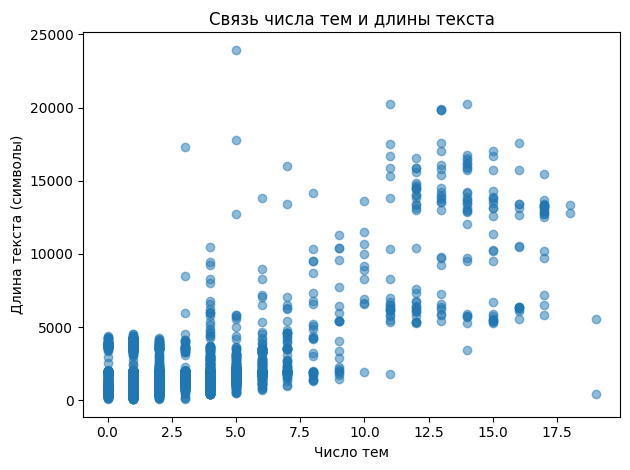

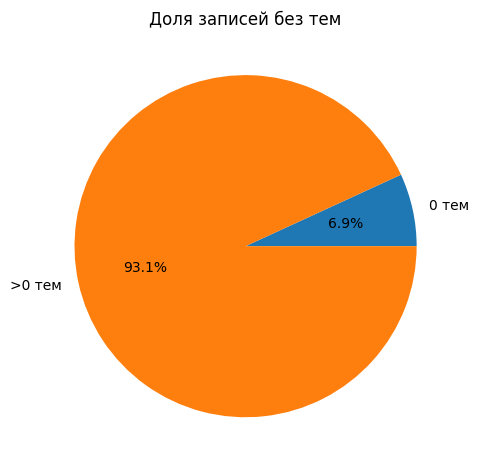

/tmp/ipykernel_13484/85253929.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

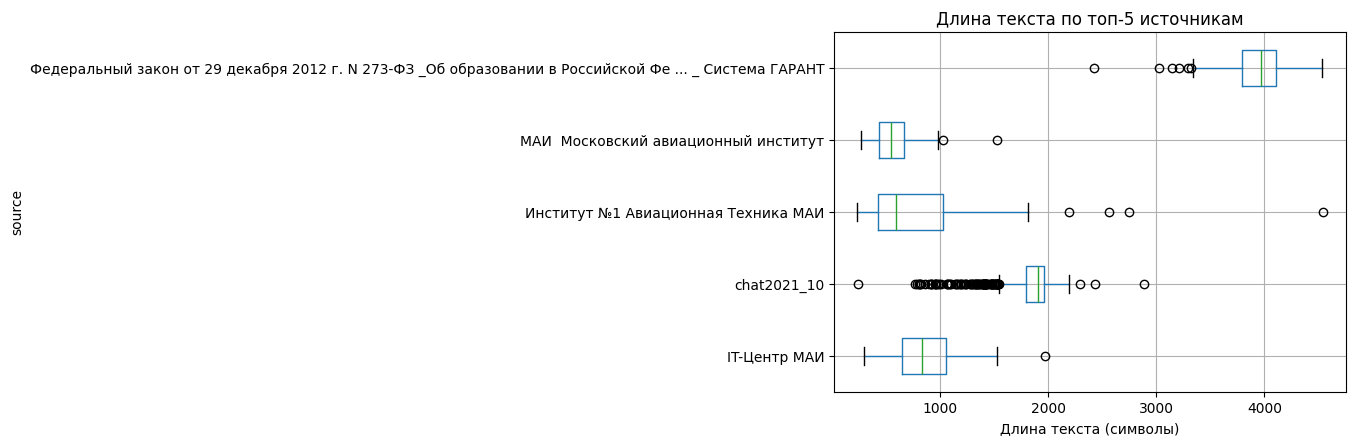

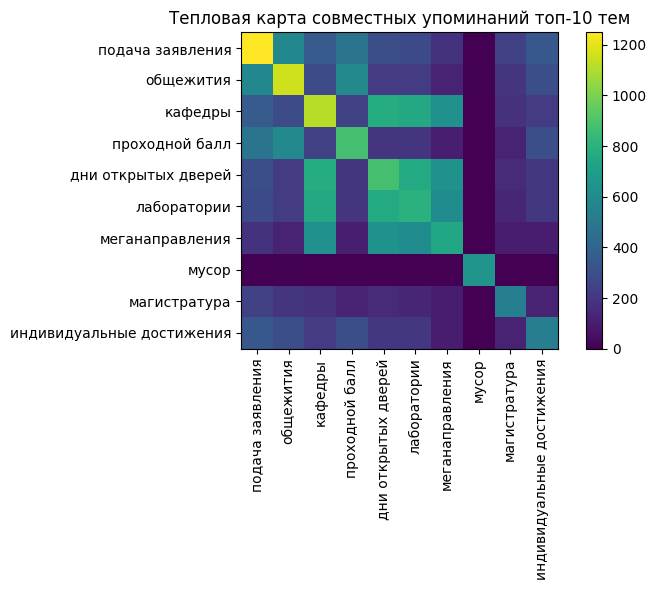

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from itertools import combinations

# Предполагаем, что df уже загружен в окружение
# Если нет, загрузите его до запуска кода

# Преобразуем темы и вычислим нужные метрики
df['topics_list'] = df['topics'].apply(ast.literal_eval)
df['num_topics'] = df['topics_list'].apply(len)
df['text_length'] = df['chunk_text'].str.len()

# 1) Scatter: число тем vs длина текста
plt.figure()
plt.scatter(df['num_topics'], df['text_length'], alpha=0.5)
plt.title('Связь числа тем и длины текста')
plt.xlabel('Число тем')
plt.ylabel('Длина текста (символы)')
plt.tight_layout()
plt.show()

# 2) Pie: доля записей без тем
empty = (df['num_topics'] == 0).sum()
non_empty = len(df) - empty
plt.figure()
plt.pie([empty, non_empty], labels=['0 тем','>0 тем'], autopct='%1.1f%%')
plt.title('Доля записей без тем')
plt.tight_layout()
plt.show()

# 3) Boxplot длины текста по топ-5 источникам
top5 = df['source'].value_counts().head(5).index
plt.figure()
df[df['source'].isin(top5)].boxplot(column='text_length', by='source', vert=False)
plt.title('Длина текста по топ-5 источникам')
plt.suptitle('')
plt.xlabel('Длина текста (символы)')
plt.tight_layout()
plt.show()

# 4) Тепловая карта совместных упоминаний топ-10 тем
top10 = df['topics_list'].explode().value_counts().head(10).index.tolist()
cooc = pd.DataFrame(0, index=top10, columns=top10)

for topics in df['topics_list']:
    filtered = [t for t in topics if t in top10]
    for a, b in combinations(filtered, 2):
        cooc.loc[a, b] += 1
        cooc.loc[b, a] += 1

# Подставим частоты для диагонали
diag = df['topics_list'].explode().value_counts().loc[top10]
np.fill_diagonal(cooc.values, diag.values)

plt.figure(figsize=(8, 6))
plt.imshow(cooc)
plt.colorbar()
plt.xticks(range(len(top10)), top10, rotation=90)
plt.yticks(range(len(top10)), top10)
plt.title('Тепловая карта совместных упоминаний топ-10 тем')
plt.tight_layout()
plt.show()


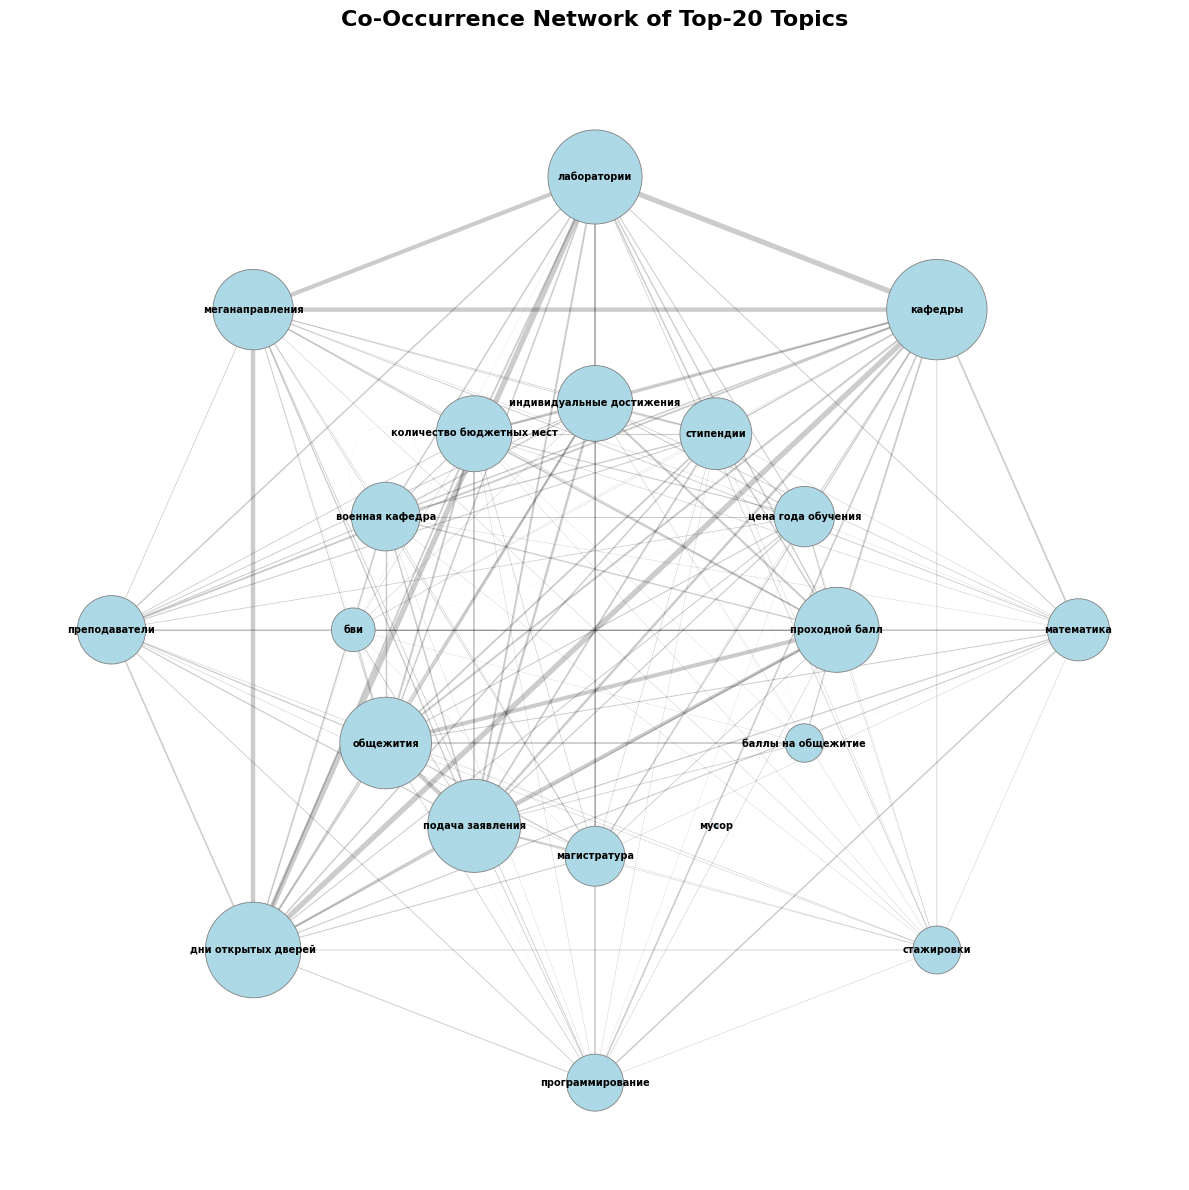

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from networkx.algorithms import community

# --- Сборка графа по топ-20 тем ---
top20 = all_topics.value_counts().head(20).index.tolist()
G = nx.Graph()
G.add_nodes_from(top20)
for topics in df['topics_list']:
    filtered = [t for t in topics if t in top20]
    for a, b in combinations(filtered, 2):
        if G.has_edge(a, b):
            G[a][b]['weight'] += 1
        else:
            G.add_edge(a, b, weight=1)

# Размер нод по степени, без умножения (еще мельче)
deg = dict(G.degree(weight='weight'))
node_sizes = [deg[n] for n in G.nodes()]  # мультипликатор=1

# Кластеризация и shell-layout
communities = list(community.greedy_modularity_communities(G, weight='weight'))
nlist = [list(c) for c in communities]
pos = nx.shell_layout(G, nlist=nlist)

plt.figure(figsize=(12,12))
nx.draw_networkx_edges(
    G, pos,
    alpha=0.2,
    width=[G[u][v]['weight'] * 0.005 for u, v in G.edges()]
)
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color='lightblue',
    edgecolors='gray',
    linewidths=0.6
)
nx.draw_networkx_labels(
    G, pos,
    font_size=7,
    font_weight='bold'
)

# ... ваш код по построению графика ...

plt.title('Co-Occurrence Network of Top-20 Topics', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Сначала сохраняем
output_path = '../data/charts/cooc_network.png'
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

plt.savefig(output_path, dpi=300, bbox_inches='tight')

# А потом показываем
plt.show()



In [22]:
from pyvis.network import Network

net = Network(height='800px', width='100%', bgcolor='#ffffff', font_color='black')
for n in G.nodes():
    net.add_node(n, label=n, value=deg[n])
for u, v, data in G.edges(data=True):
    net.add_edge(u, v, value=data['weight'])
net.show('topics_network.html')


ModuleNotFoundError: No module named 'pyvis'

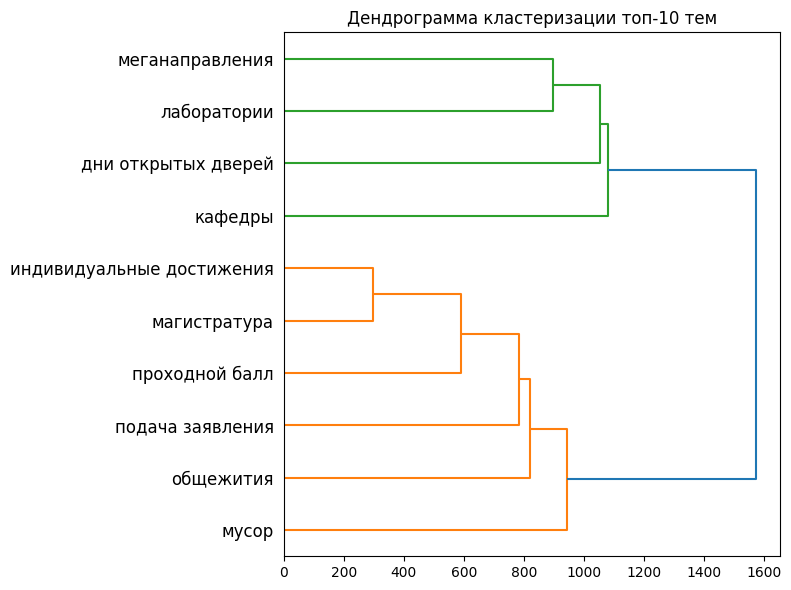

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(cooc, method='ward')
plt.figure(figsize=(8, 6))
dendrogram(Z, labels=top10, orientation='right')
plt.title('Дендрограмма кластеризации топ-10 тем')
plt.tight_layout()
plt.show()


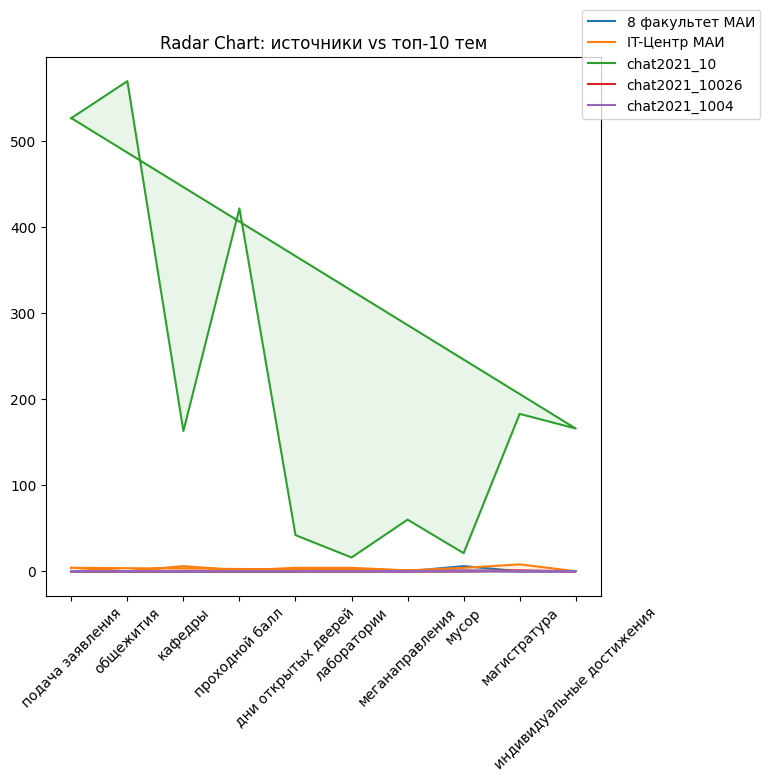

In [26]:
import numpy as np

# Подготовка данных: доля упоминаний топ-10 тем в каждом из топ-5 источников
links = df.explode('topics_list').groupby(['source','topics_list']).size().unstack(fill_value=0)
sources = links.index[:5]
top10 = all_topics.value_counts().head(10).index
data = links.loc[sources, top10]

# Координаты углов
angles = np.linspace(0, 2*np.pi, len(top10), endpoint=False).tolist()
angles += angles[:1]  # замкнуть круг

plt.figure(figsize=(8,8))
for src in sources:
    values = data.loc[src].values.tolist()
    values += values[:1]
    plt.plot(angles, values, label=src)
    plt.fill(angles, values, alpha=0.1)
plt.xticks(angles[:-1], top10, rotation=45)
plt.title('Radar Chart: источники vs топ-10 тем')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [28]:
from mido import Message, MidiFile, MidiTrack
mid, track = MidiFile(), MidiTrack()
mid.tracks.append(track)
for (a,b),w in top_pairs.items():
    note = 60 + top20.index(a)  # базовая нота
    track.append(Message('note_on', note=note, velocity=w*5, time=100))
mid.save('topics_sound.mid')


NameError: name 'top_pairs' is not defined